# 2. Entrenamiento de RNNs en una Serie de Tiempo

#### (a) Se carga el dataset y se escala.

In [1]:
import pandas

dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[0:96].values, dataframe[96:].values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

#### (b) Definición del creador del dataset.

In [2]:
import numpy as np

def create_dataset(dataset, lag=1):
    dataX = []
    dataY = []
    for i in range((len(dataset)-1)-lag):
        dataX.append(dataset[i:i+lag])
        dataY.append(dataset[i+lag])
    return np.array(dataX), np.array(dataY)

#### (c) Creación del dataset para trabajar.

In [3]:
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

#### (d) Transformación del dataset a la estructura requerida por la LSTM: [samples, time_steps, features]

In [4]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### (e) Entrenamiento de LSTM, con lag = 3.

In [114]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

modelo2 = Sequential()
modelo2.add(LSTM(4, input_shape=(1, lag), activation='tanh', recurrent_activation='sigmoid'))
modelo2.add(Dense(1))

modelo2.compile(loss='mean_squared_error', optimizer='adam')
resultados2=modelo2.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
92/92 [==============================] - 1s - loss: 0.1089     
Epoch 2/100
92/92 [==============================] - 0s - loss: 0.0465     
Epoch 3/100
92/92 [==============================] - 0s - loss: 0.0246     
Epoch 4/100
92/92 [==============================] - 0s - loss: 0.0199     
Epoch 5/100
92/92 [==============================] - 0s - loss: 0.0181     
Epoch 6/100
92/92 [==============================] - 0s - loss: 0.0166     
Epoch 7/100
92/92 [==============================] - 0s - loss: 0.0153     
Epoch 8/100
92/92 [==============================] - 0s - loss: 0.0143     
Epoch 9/100
92/92 [==============================] - 0s - loss: 0.0135     
Epoch 10/100
92/92 [==============================] - 0s - loss: 0.0126     
Epoch 11/100
92/92 [==============================] - 0s - loss: 0.0121     
Epoch 12/100
92/92 [==============================] - 0s - loss: 0.0116     
Epoch 13/100
92/92 [==============================] - 0s - loss: 0.0116     
Epoch 14

#### (f) Realización de predicciones en base a los conjuntos de entrenamiento y prueba, usando el modelo recién entrenado.

In [115]:
trainPredict = modelo2.predict(trainX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)

testPredict = modelo2.predict(testX)

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

#### (g) Cálculo del RMSE (Root Mean Squared Error) sobre conjuntos de entrenamiento y prueba.

In [116]:
from sklearn.metrics import mean_squared_error
import math

trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.82 RMSE
Test Score: 60.61 RMSE


#### (h) Gráfica de predicciones sobre el conjunto de entrenamiento y prueba. Contraste con la serie original.

c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


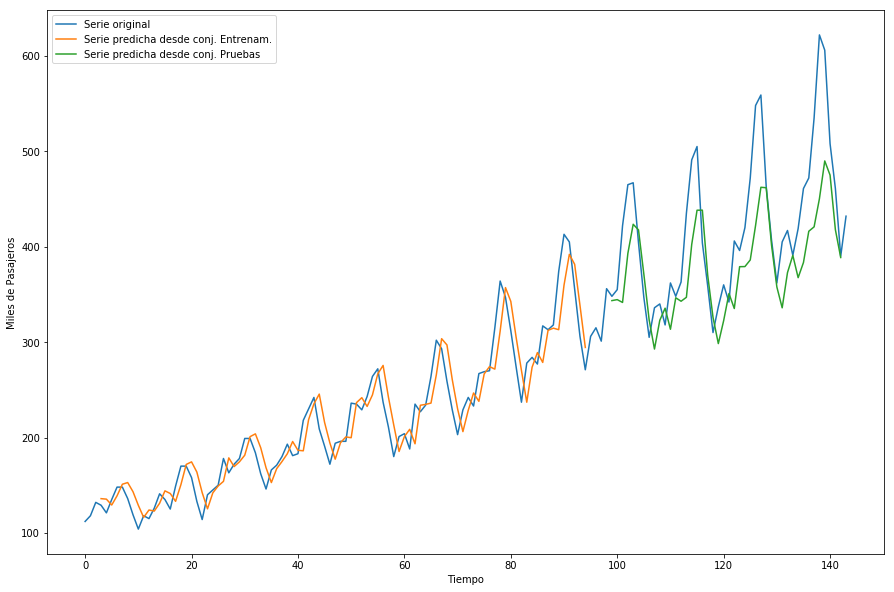

In [132]:
import matplotlib.pyplot as plt

trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict

testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(2*lag)+1:len(dataframe.values)-1, :] = testPredict

plt.subplots(1,1,figsize=(15,10))
plt.subplot(1,1,1)
plt.plot(scaler.inverse_transform(np.append(stream_train_scaled, stream_test_scaled)), label='Serie original')
plt.plot(trainPredictPlot, label='Serie predicha desde conj. Entrenam.')
plt.plot(testPredictPlot, label='Serie predicha desde conj. Pruebas')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.legend(loc='upper left')
plt.show()

Como es de esperarse, la predicción basada en la serie del conjunto de entrenamiento (línea naranja) se ajusta muy bien a la original (azul), pues en ésta se basó su entrenamiento. Esto cambia cuando se intenta predecir en base a la parte de la serie usada para prueba (verde), donde, en la serie original, se observa que los peaks de pasajeros aumentan de forma más pronunciada conforme avanza el tiempo. Se nota que la red LSTM predice aproximadamente bien la cantidad de pasajeros en los valles, pero subestima notoriamente los peaks: justo antes del tiempo $t=140$, el flujo real de pasajeros sobrepasa por aproximadamente 150 mil lo predicho por la red.

Notar que la línea verde no está presente en $t \in [96, 98]$, pues esas tres etapas de tiempo se necesitaron para comenzar a construir la predicción, ya que se eligió $lag = 3$. Ocurre lo mismo con la predicción de entrenamiento (naranja) en $t \in [0, 2]$.

#### (h) Determinación de número de bloques LSTM usando 5-fold Cross Validation.

In [48]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import KFold

lag = 3

kf = KFold(n_splits = 5)

dataset = np.append(stream_train_scaled, stream_test_scaled, axis=0) #dataset completo y escalado
resultados2_h = {}
folds = {}
i = 0
for train_index, test_index in kf.split(dataset):
    trainX, trainY = create_dataset(dataset[train_index], lag=3)
    testX, testY = create_dataset(dataset[test_index], lag=3)
    
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    i += 1
    folds['fold_%d' % i] = {}
    folds['fold_%d' % i]['trainX'] = trainX
    folds['fold_%d' % i]['trainY'] = trainY
    folds['fold_%d' % i]['testX'] = testX
    folds['fold_%d' % i]['testY'] = testY
    resultados2_h['fold_%d' % i] = {}
    
    for nb in range(4,13, 2):
        modelo2_h_aux = Sequential()
        modelo2_h_aux.add(LSTM(nb, input_shape=(1, lag), activation='tanh', recurrent_activation='sigmoid'))
        modelo2_h_aux.add(Dense(1))
        modelo2_h_aux.compile(loss='mean_squared_error', optimizer='adam')
        
        results = modelo2_h_aux.fit(trainX, trainY, validation_data=(testX, testY),
                                    epochs=100, batch_size=1, verbose=1)
        resultados2_h['fold_%d' % i]['%d_units' % nb] = results.history

Train on 111 samples, validate on 25 samples
Epoch 1/100
111/111 [==============================] - 13s - loss: 0.6203 - val_loss: 0.0050
Epoch 2/100
111/111 [==============================] - 0s - loss: 0.2846 - val_loss: 0.0347
Epoch 3/100
111/111 [==============================] - 0s - loss: 0.1317 - val_loss: 0.0770
Epoch 4/100
111/111 [==============================] - 0s - loss: 0.0707 - val_loss: 0.1021
Epoch 5/100
111/111 [==============================] - 0s - loss: 0.0545 - val_loss: 0.1012
Epoch 6/100
111/111 [==============================] - 0s - loss: 0.0471 - val_loss: 0.0891
Epoch 7/100
111/111 [==============================] - 0s - loss: 0.0419 - val_loss: 0.0747
Epoch 8/100
111/111 [==============================] - 0s - loss: 0.0370 - val_loss: 0.0656
Epoch 9/100
111/111 [==============================] - 0s - loss: 0.0332 - val_loss: 0.0512
Epoch 10/100
111/111 [==============================] - 0s - loss: 0.0297 - val_loss: 0.0410
Epoch 11/100
111/111 [===========

En el diccionario "resultados2_h" se almacenan, para cada uno de los 5 folds, el history del entrenamiento de la red LSTM usando lag = 3, y con cantidad de unidades o bloques distintas: $nb \in \{4, 6, 8, 10, 12\}$.

In [49]:
resultados2_h.keys()

dict_keys(['fold_4', 'fold_1', 'fold_3', 'fold_5', 'fold_2'])

In [50]:
resultados2_h['fold_1'].keys()

dict_keys(['12_units', '8_units', '4_units', '10_units', '6_units'])

Para cada cantidad de unidades $nb$ probada ($nb \in \{4, 6, 8, 10, 12\}$), se promediará el loss de validación alcanzado por la red LSTM entre los cinco folds. Esto entregará, finalmente, cinco losses promedio, de los cuales el menor corresponderá a la cantidad de unidades óptima en la red.

In [54]:
mean_val_losses = []
print('Loss de Validacion promedio')
for nb in range(4,13, 2):
    aux1 = resultados2_h['fold_1']['%d_units' % nb]['val_loss'][-1]
    aux2 = resultados2_h['fold_2']['%d_units' % nb]['val_loss'][-1]
    aux3 = resultados2_h['fold_3']['%d_units' % nb]['val_loss'][-1]
    aux4 = resultados2_h['fold_4']['%d_units' % nb]['val_loss'][-1]
    aux5 = resultados2_h['fold_5']['%d_units' % nb]['val_loss'][-1]
    mean = np.mean(np.array([aux1,aux2,aux3,aux4,aux5]))
    mean_val_losses.append(mean)
    print('Val. Loss alcanzado con %d unidades: %.5f' % (nb, mean))
    

Loss de Validacion promedio
Val. Loss alcanzado con 4 unidades: 0.01446
Val. Loss alcanzado con 6 unidades: 0.01046
Val. Loss alcanzado con 8 unidades: 0.01308
Val. Loss alcanzado con 10 unidades: 0.01426
Val. Loss alcanzado con 12 unidades: 0.01339


Por lo tanto, se elijen 6 unidades para conformar la red LSTM, por converger al menor loss de validación: $0.01046$.

#### (i) Comparación de desempeño usando $lag \in \{1, 2, 3, 4\}$.

Se elige la cantidad de unidades determinada como óptima en el ítem anterior: $nb = 6$.

In [60]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

resultados2_i = {}

for lag in range(1, 5): # lag = 1, 2, 3, 4.
    
    # train data se constituye por los primeros 96 datos de la serie; test data con el resto.
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    testX, testY = create_dataset(stream_test_scaled, lag)

    # reshaping de datos X
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # definicion de la red LSTM
    modelo2_i = Sequential()
    modelo2_i.add(LSTM(6, input_shape=(1, lag), activation='tanh', recurrent_activation='sigmoid'))
    modelo2_i.add(Dense(1))
    modelo2_i.compile(loss='mean_squared_error', optimizer='adam')

    results = modelo2_i.fit(trainX, trainY, validation_data=(testX, testY),
                                epochs=100, batch_size=1, verbose=1)
    resultados2_i['lag_of_%d' % lag] = results.history

Train on 94 samples, validate on 46 samples
Epoch 1/100
94/94 [==============================] - 5s - loss: 0.0924 - val_loss: 0.5466
Epoch 2/100
94/94 [==============================] - 0s - loss: 0.0444 - val_loss: 0.3571
Epoch 3/100
94/94 [==============================] - 0s - loss: 0.0295 - val_loss: 0.2690
Epoch 4/100
94/94 [==============================] - 0s - loss: 0.0245 - val_loss: 0.2242
Epoch 5/100
94/94 [==============================] - 0s - loss: 0.0215 - val_loss: 0.1774
Epoch 6/100
94/94 [==============================] - 0s - loss: 0.0186 - val_loss: 0.1461
Epoch 7/100
94/94 [==============================] - 0s - loss: 0.0157 - val_loss: 0.1308
Epoch 8/100
94/94 [==============================] - 0s - loss: 0.0133 - val_loss: 0.1011
Epoch 9/100
94/94 [==============================] - 0s - loss: 0.0109 - val_loss: 0.0899
Epoch 10/100
94/94 [==============================] - 0s - loss: 0.0093 - val_loss: 0.0674
Epoch 11/100
94/94 [==============================] - 0

En el diccionario "resultados2_i" se encuentra el history de entrenamiento de la red para los lags desde 1 hasta 4.

In [61]:
resultados2_i.keys()

dict_keys(['lag_of_3', 'lag_of_4', 'lag_of_1', 'lag_of_2'])

In [62]:
for lag in range(1,5):
    print('Val. Loss alcanzado con lag = %d: %.5f' % (lag, resultados2_i['lag_of_'+str(lag)]['val_loss'][-1]))

Val. Loss alcanzado con lag = 1: 0.03048
Val. Loss alcanzado con lag = 2: 0.02890
Val. Loss alcanzado con lag = 3: 0.05507
Val. Loss alcanzado con lag = 4: 0.04129


#### (j) Comparación de una red LSTM de lag = 3 con una RNN simple y una GRU.

En las tres redes a comparar, se usarán 6 unidades.

Se genera el dataset con un lag igual a 3.

In [66]:
# Dataset con lag = 3
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)

# reshaping de datos X
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Se vuelve a definir y a entrenar una red LSTM con lag igual a 3.

In [70]:
# LSTM
modelo2_j_lstm = Sequential()
modelo2_j_lstm.add(LSTM(6, input_shape=(1, lag), activation='tanh', recurrent_activation='sigmoid'))
modelo2_j_lstm.add(Dense(1))
modelo2_j_lstm.compile(loss='mean_squared_error', optimizer='adam')

results = modelo2_j_lstm.fit(trainX, trainY, validation_data=(testX, testY),
                            epochs=100, batch_size=1, verbose=1)
resultados2_j_lstm = results.history

Train on 92 samples, validate on 44 samples
Epoch 1/100
92/92 [==============================] - 4s - loss: 0.1380 - val_loss: 0.6602
Epoch 2/100
92/92 [==============================] - 0s - loss: 0.0549 - val_loss: 0.3509
Epoch 3/100
92/92 [==============================] - 0s - loss: 0.0268 - val_loss: 0.2135
Epoch 4/100
92/92 [==============================] - 0s - loss: 0.0203 - val_loss: 0.1564
Epoch 5/100
92/92 [==============================] - 0s - loss: 0.0174 - val_loss: 0.1326
Epoch 6/100
92/92 [==============================] - 0s - loss: 0.0148 - val_loss: 0.1104
Epoch 7/100
92/92 [==============================] - 0s - loss: 0.0128 - val_loss: 0.0961
Epoch 8/100
92/92 [==============================] - 0s - loss: 0.0113 - val_loss: 0.0814
Epoch 9/100
92/92 [==============================] - 0s - loss: 0.0103 - val_loss: 0.0683
Epoch 10/100
92/92 [==============================] - 0s - loss: 0.0094 - val_loss: 0.0639
Epoch 11/100
92/92 [==============================] - 0

Se define y entrena la red GRU.

In [67]:
from keras.layers import GRU, SimpleRNN
# GRU
modelo2_j_gru = Sequential()
modelo2_j_gru.add(GRU(6, input_shape=(1, lag), activation='tanh', kernel_initializer='orthogonal'))
modelo2_j_gru.add(Dense(1))
modelo2_j_gru.compile(loss='mean_squared_error', optimizer='adam')

results = modelo2_j_gru.fit(trainX, trainY, validation_data=(testX, testY),
                            epochs=100, batch_size=1, verbose=1)
resultados2_j_gru = results.history

Train on 92 samples, validate on 44 samples
Epoch 1/100
92/92 [==============================] - 6s - loss: 0.1011 - val_loss: 0.4594
Epoch 2/100
92/92 [==============================] - 0s - loss: 0.0350 - val_loss: 0.2282
Epoch 3/100
92/92 [==============================] - 0s - loss: 0.0243 - val_loss: 0.1745
Epoch 4/100
92/92 [==============================] - 0s - loss: 0.0220 - val_loss: 0.1700
Epoch 5/100
92/92 [==============================] - 0s - loss: 0.0200 - val_loss: 0.1488
Epoch 6/100
92/92 [==============================] - 0s - loss: 0.0182 - val_loss: 0.1233
Epoch 7/100
92/92 [==============================] - 0s - loss: 0.0172 - val_loss: 0.1084
Epoch 8/100
92/92 [==============================] - 0s - loss: 0.0159 - val_loss: 0.1027
Epoch 9/100
92/92 [==============================] - 0s - loss: 0.0152 - val_loss: 0.0823
Epoch 10/100
92/92 [==============================] - 0s - loss: 0.0144 - val_loss: 0.0851
Epoch 11/100
92/92 [==============================] - 0

Se define y entrena la red recurrente simple.

In [69]:
# SimpleRNN
modelo2_j_srnn = Sequential()
modelo2_j_srnn.add(SimpleRNN(6, input_shape=(1, lag), activation='tanh', kernel_initializer='orthogonal'))
modelo2_j_srnn.add(Dense(1))
modelo2_j_srnn.compile(loss='mean_squared_error', optimizer='adam')

results = modelo2_j_srnn.fit(trainX, trainY, validation_data=(testX, testY),
                            epochs=100, batch_size=1, verbose=1)
resultados2_j_srnn = results.history

Train on 92 samples, validate on 44 samples
Epoch 1/100
92/92 [==============================] - 3s - loss: 0.5652 - val_loss: 2.6355
Epoch 2/100
92/92 [==============================] - 0s - loss: 0.2024 - val_loss: 1.4387
Epoch 3/100
92/92 [==============================] - 0s - loss: 0.0969 - val_loss: 0.9229
Epoch 4/100
92/92 [==============================] - 0s - loss: 0.0684 - val_loss: 0.6988
Epoch 5/100
92/92 [==============================] - 0s - loss: 0.0551 - val_loss: 0.5269
Epoch 6/100
92/92 [==============================] - 0s - loss: 0.0439 - val_loss: 0.4527
Epoch 7/100
92/92 [==============================] - 0s - loss: 0.0351 - val_loss: 0.3994
Epoch 8/100
92/92 [==============================] - 0s - loss: 0.0270 - val_loss: 0.3136
Epoch 9/100
92/92 [==============================] - 0s - loss: 0.0210 - val_loss: 0.2626
Epoch 10/100
92/92 [==============================] - 0s - loss: 0.0160 - val_loss: 0.2101
Epoch 11/100
92/92 [==============================] - 0

Comparación de rendimiento entre las tres redes.

c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single 

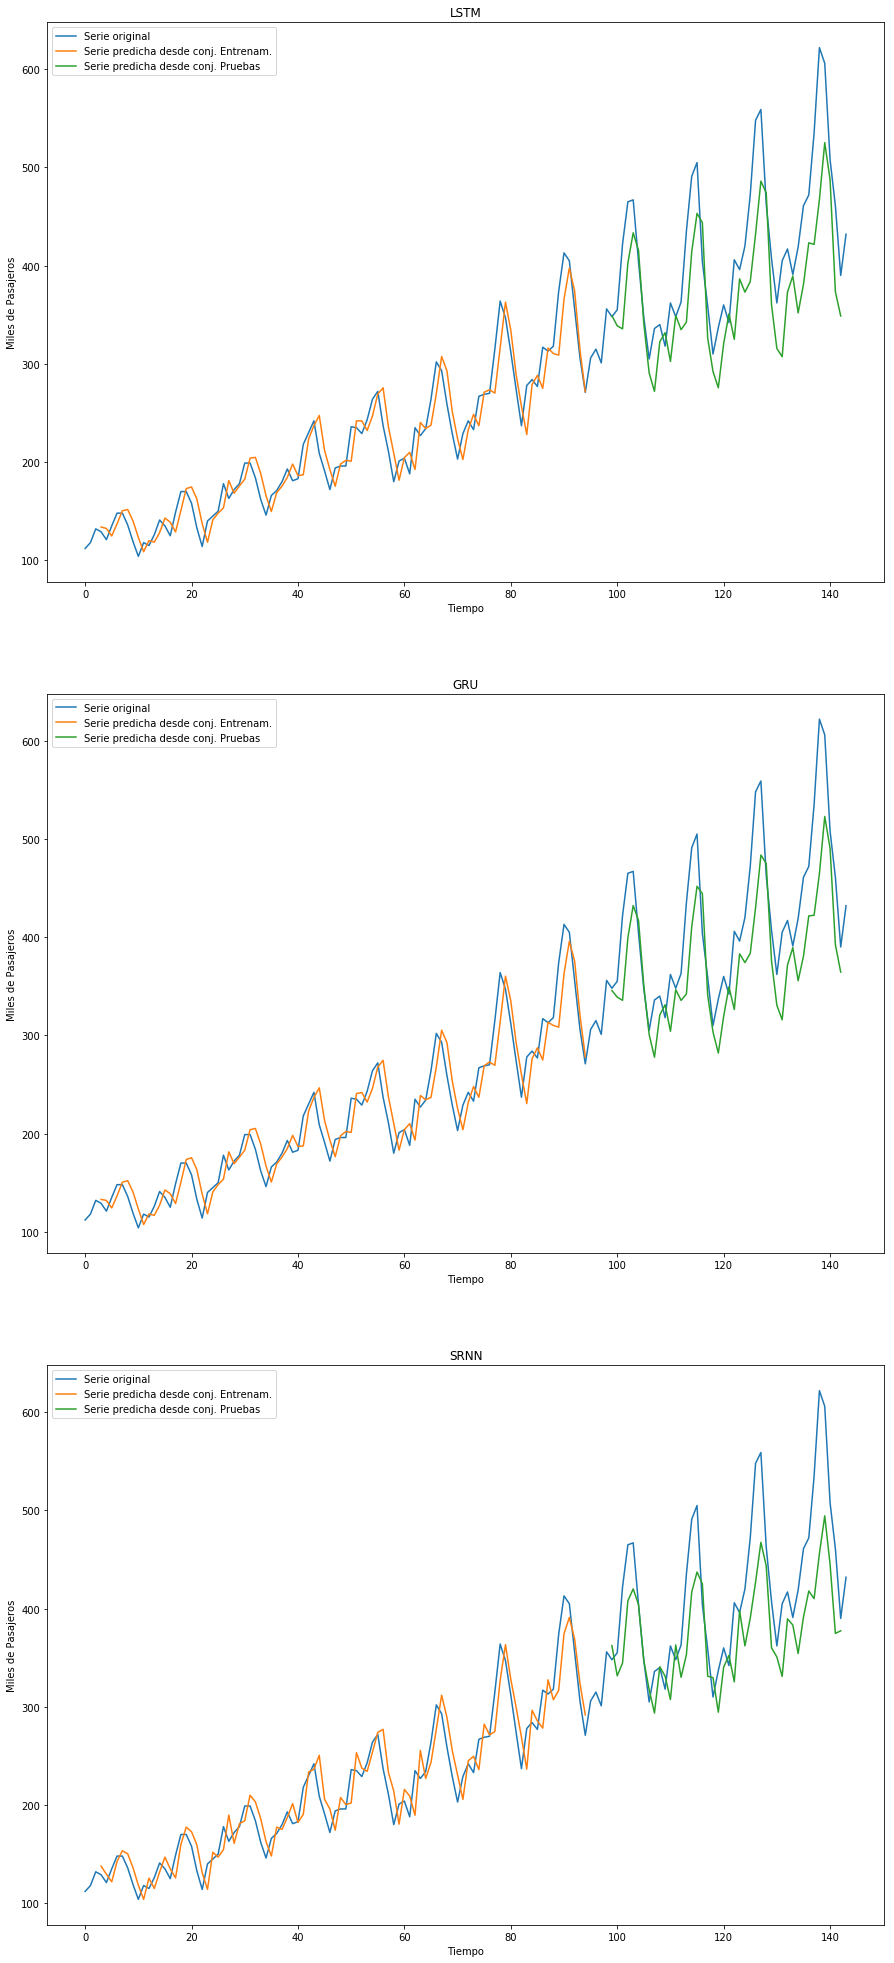

In [74]:
import matplotlib.pyplot as plt

# escalado inverso de las predicciones
trainPredict_lstm = modelo2_j_lstm.predict(trainX)
trainPredict_lstm = scaler.inverse_transform(trainPredict_lstm)
trainPredict_gru = modelo2_j_gru.predict(trainX)
trainPredict_gru = scaler.inverse_transform(trainPredict_gru)
trainPredict_srnn = modelo2_j_srnn.predict(trainX)
trainPredict_srnn = scaler.inverse_transform(trainPredict_srnn)
trainY = scaler.inverse_transform(trainY)

testPredict_lstm = modelo2_j_lstm.predict(testX)
testPredict_lstm = scaler.inverse_transform(testPredict_lstm)
testPredict_gru = modelo2_j_gru.predict(testX)
testPredict_gru = scaler.inverse_transform(testPredict_gru)
testPredict_srnn = modelo2_j_srnn.predict(testX)
testPredict_srnn = scaler.inverse_transform(testPredict_srnn)
testY = scaler.inverse_transform(testY)

# plotting
trainPredictPlot_lstm = np.empty_like(dataframe.values)
trainPredictPlot_lstm[:, :] = np.nan
trainPredictPlot_lstm[lag:len(trainPredict_lstm)+lag, :] = trainPredict_lstm

trainPredictPlot_gru = np.empty_like(dataframe.values)
trainPredictPlot_gru[:, :] = np.nan
trainPredictPlot_gru[lag:len(trainPredict_gru)+lag, :] = trainPredict_gru

trainPredictPlot_srnn = np.empty_like(dataframe.values)
trainPredictPlot_srnn[:, :] = np.nan
trainPredictPlot_srnn[lag:len(trainPredict_srnn)+lag, :] = trainPredict_srnn

testPredictPlot_lstm = np.empty_like(dataframe.values)
testPredictPlot_lstm[:, :] = np.nan
testPredictPlot_lstm[len(trainPredict_lstm)+(2*lag)+1:len(dataframe.values)-1, :] = testPredict_lstm

testPredictPlot_gru = np.empty_like(dataframe.values)
testPredictPlot_gru[:, :] = np.nan
testPredictPlot_gru[len(trainPredict_gru)+(2*lag)+1:len(dataframe.values)-1, :] = testPredict_gru

testPredictPlot_srnn = np.empty_like(dataframe.values)
testPredictPlot_srnn[:, :] = np.nan
testPredictPlot_srnn[len(trainPredict_srnn)+(2*lag)+1:len(dataframe.values)-1, :] = testPredict_srnn

plt.subplots(3,1,figsize=(15,35))
plt.subplot(3,1,1)
plt.plot(scaler.inverse_transform(np.append(stream_train_scaled, stream_test_scaled)), label='Serie original')
plt.plot(trainPredictPlot_lstm, label='Serie predicha desde conj. Entrenam.')
plt.plot(testPredictPlot_lstm, label='Serie predicha desde conj. Pruebas')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.legend(loc='upper left')
plt.title('LSTM')
plt.subplot(3,1,2)
plt.plot(scaler.inverse_transform(np.append(stream_train_scaled, stream_test_scaled)), label='Serie original')
plt.plot(trainPredictPlot_gru, label='Serie predicha desde conj. Entrenam.')
plt.plot(testPredictPlot_gru, label='Serie predicha desde conj. Pruebas')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.legend(loc='upper left')
plt.title('GRU')
plt.subplot(3,1,3)
plt.plot(scaler.inverse_transform(np.append(stream_train_scaled, stream_test_scaled)), label='Serie original')
plt.plot(trainPredictPlot_srnn, label='Serie predicha desde conj. Entrenam.')
plt.plot(testPredictPlot_srnn, label='Serie predicha desde conj. Pruebas')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.legend(loc='upper left')
plt.title('SRNN')
plt.show()

Gráficamente, se observa un rendimiento muy bueno y similar en las predicciones a partir del conjunto de entrenamiento de las redes LSTM, GR y SRNN. El loss de entrenamiento es, para cada red:

In [80]:
print('Loss LSTM:',resultados2_j_lstm['loss'][-1])
print('Loss GRU:',resultados2_j_gru['loss'][-1])
print('Loss SRNN:',resultados2_j_srnn['loss'][-1])

Loss LSTM: 0.00524943963864
Loss GRU: 0.00520941846301
Loss SRNN: 0.00513823136445


Se nota que, efectivamente, el loss de entramiento es aproximadamente igual y bastante bajo para las tres redes.

Durante las predicciones de la serie de prueba, se observa que, a simple vista, tanto la red LSTM como la GRU parecen desempeñarse a un nivel similar y superior al de la SRNN. El loss de validación es, para cada red:

In [82]:
print('Val. Loss LSTM:',resultados2_j_lstm['val_loss'][-1])
print('Val. Loss GRU:',resultados2_j_gru['val_loss'][-1])
print('Val. Loss SRNN:',resultados2_j_srnn['val_loss'][-1])

Val. Loss LSTM: 0.0393321268281
Val. Loss GRU: 0.0374361174194
Val. Loss SRNN: 0.0397031387521


Sin embargo, el resultado indica que tanto la red LSTM como la SRNN se desempeñan de forma similar y peor que la GRU. Esto se explica porque la predicción de la LSTM, si bien es de una calidad similar a la de la GRU en los peaks, estima de peor manera los mínimos, desempeñandose peor que la GRU en esas partes de la serie.

Se puede observar cómo tanto la red LSTM como la GRU intentan sutilmente emular la tendencia del patrón a incrementar, en promedio, de manera similar a una exponencial, lo que se da en la serie original:

c:\program files\python35\lib\site-packages\sklearn\preprocessing\data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
c:\program files\python35\lib\site-packages\numpy\core\fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\program files\python35\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


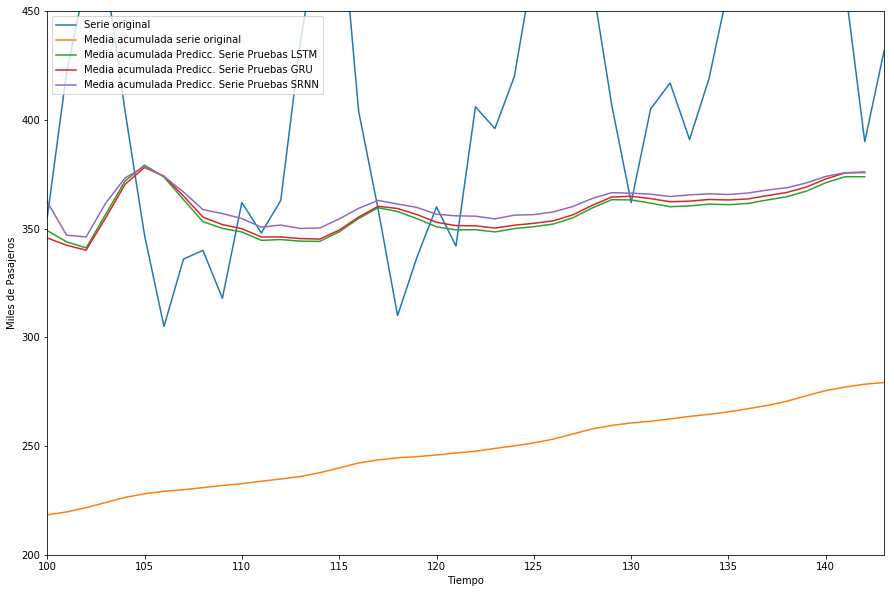

In [134]:
import matplotlib.pyplot as plt

serie_original = scaler.inverse_transform(np.append(stream_train_scaled, stream_test_scaled))
media_acumulada_de_la_serie = np.array([])
for i in range(len(serie_original)):
    media_acumulada_de_la_serie=np.append(media_acumulada_de_la_serie, np.mean(serie_original[:i]))

media_acumulada_lstm = []
for i in range(len(testPredict_lstm)):
    media_acumulada_lstm.append(np.array([np.mean(testPredict_lstm[:i])]))

media_acumulada_lstm = np.array(media_acumulada_lstm)
media_testPredictPlot_lstm = np.empty_like(dataframe.values)
media_testPredictPlot_lstm[:, :] = np.nan
media_testPredictPlot_lstm[len(trainPredict_lstm)+(2*lag)+1:len(dataframe.values)-1, :] = media_acumulada_lstm

media_acumulada_gru = []
for i in range(len(testPredict_gru)):
    media_acumulada_gru.append(np.array([np.mean(testPredict_gru[:i])]))

media_acumulada_gru = np.array(media_acumulada_gru)
media_testPredictPlot_gru = np.empty_like(dataframe.values)
media_testPredictPlot_gru[:, :] = np.nan
media_testPredictPlot_gru[len(trainPredict_gru)+(2*lag)+1:len(dataframe.values)-1, :] = media_acumulada_gru

media_acumulada_srnn = []
for i in range(len(testPredict_srnn)):
    media_acumulada_srnn.append(np.array([np.mean(testPredict_srnn[:i])]))

media_acumulada_srnn = np.array(media_acumulada_srnn)
media_testPredictPlot_srnn = np.empty_like(dataframe.values)
media_testPredictPlot_srnn[:, :] = np.nan
media_testPredictPlot_srnn[len(trainPredict_srnn)+(2*lag)+1:len(dataframe.values)-1, :] = media_acumulada_srnn

plt.subplots(1,1,figsize=(15,10))
plt.subplot(1,1,1)
plt.plot(serie_original, label='Serie original')
plt.plot(media_acumulada_de_la_serie, label='Media acumulada serie original')
plt.plot(range(len(trainPredict_lstm)+(2*lag)+1, len(dataframe.values)-1), media_acumulada_lstm, label='Media acumulada Predicc. Serie Pruebas LSTM')
plt.plot(range(len(trainPredict_gru)+(2*lag)+1, len(dataframe.values)-1), media_acumulada_gru, label='Media acumulada Predicc. Serie Pruebas GRU')
plt.plot(media_testPredictPlot_srnn, label='Media acumulada Predicc. Serie Pruebas SRNN')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.xlim(100,143)
plt.ylim(200,450)
plt.legend(loc='upper left')
plt.show()

Se nota ligeramente cómo la media acumulada de la predicción de la SRNN aumenta en menor medida que la de la LSTM y GRU, lo que evidencia el comportamiento mencionado anteriormente; se va aplanando con respecto a las demás.

Cualitativamente, la predicción de la red SRNN debe su comportamiento de aumento más líneal ya que para esta, lo observado en el pasado tiene un efecto en los pesos de la red que se degrada más rápidamente respecto a los de la LSTM y GRU. Es por esto que la SRNN "olvidó" o "no pudo ver" que el comportamiento general de la serie aproximaba ese aumento en promedio exponencial, y no a uno líneal. Por lo tanto, la red quizás miró muy de cerca el patrón de la serie, por lo que en vez de una curva (exponencial) vio más bien, una recta (en promedio).

Esto es distinto con las redes GRU y LSTM, las cuales sí se dieron cuenta del comportamiento general de la serie, por lo que  lo emularon ligeramente en sus predicciones.

#### (k) Entrenamiento de la red LSTM con timestep = 3 y lag = 1.

In [4]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
import numpy as np

# reshaping
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# definicion del modelo
modelo2_k = Sequential()
modelo2_k.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
modelo2_k.add(Dense(1))
modelo2_k.compile(loss='mean_squared_error', optimizer='adam')
resultados2_k = modelo2_k.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=1)


Using Theano backend.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", input_shape=(None, 1), recurrent_activation="sigmoid")`
/usr/local/lib/python2.7/dist-packages/keras/models.py:834: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '26607' (I am process '28129')


Epoch 1/100
92/92 [==============================] - 0s - loss: 0.2072     
Epoch 2/100
92/92 [==============================] - 0s - loss: 0.0911     
Epoch 3/100
92/92 [==============================] - 0s - loss: 0.0568     
Epoch 4/100
92/9

En comparación a la red LSTM entrenada en el ítem (e), cuya dimensionalidad de input era de 3 (lag=3 y timesteps=1), se nota que el rendimiento (loss) alcanzado es peor: con timesteps=3, el loss es $0.0082$, mientras que en el modelo del ítem (e), el loss alcanzado fue de $0.0058$.

No es posible comparar cuantitativamente los tiempos de ejecución del entrenamiento, pues ambos se completaron rápidamente. Sin embargo, en problemas de aprendizaje más complejos, se esperaría que el modelo de menor timestep entrene más rápido, precisamente a causa de la reducción de la dimensionalidad del input. Esto, por supuesto, viene con la desventaja de que el modelo muy probablemente ofrezca predicciones de peor calidad que las que daría otro más complejo, como es el caso observado ahora.

#### (l) Entrenamiento de la red LSTM con memoria entre batches, usando batch_size = 1 y lag = 3.

In [20]:
bs = 1
lag = 3

# En el siguiente íem, el tamaño de trainX debe ser divisible
# por 3. Actualmente, su tamaño es de 92, por lo que se reformará
# el dataset para que su tamaño sea 93, añadiendo al final de trainX
# el primer dato de testX.
trainX, trainY = create_dataset(np.append(stream_train_scaled,[stream_test_scaled[-1]], axis=0), lag)
testX, testY = create_dataset(stream_test_scaled[1:], lag)


modelo2_l = Sequential()
modelo2_l.add(LSTM(4, batch_input_shape=(bs, lag, 1), stateful=True, return_sequences=True))
modelo2_l.add(LSTM(4, batch_input_shape=(bs, lag, 1), stateful=True))
modelo2_l.add(Dense(1))
modelo2_l.compile(loss='mean_squared_error', optimizer='adam')

resultados2_l = {}
resultados2_l['loss'] = []
resultados2_l['val_loss'] = []
for i in range(100):
    aux = modelo2_l.fit(trainX, trainY, validation_data=(testX, testY), epochs=1, batch_size=bs, verbose=2, shuffle=False)
    resultados2_l['loss'].append(aux.history['loss'][0])
    resultados2_l['val_loss'].append(aux.history['val_loss'][0])
    modelo2_l.reset_states()


Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0170 - val_loss: 0.0770
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0354 - val_loss: 0.0702
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0260 - val_loss: 0.0696
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0205 - val_loss: 0.0699
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0180 - val_loss: 0.0704
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0169 - val_loss: 0.0710
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0164 - val_loss: 0.0718
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0161 - val_loss: 0.0727
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0159 - val_loss: 0.0736
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0158 - val_loss: 0.0746
Train on 93 samples, validate on 43 samples
Epoch 1/1
0s - loss: 0.0157 - val_loss: 0.0756

#### (m) Ahora usando batch_size = 3.

In [22]:
bs = 3
lag = 3

# El tamaño de trainX debe ser divisible por 3. Actualmente,
# su tamaño es de 92, por lo que se reformará el dataset
# para que su tamaño sea 93, añadiendo al final de trainX
# el primer dato de testX.
trainX, trainY = create_dataset(np.append(stream_train_scaled,[stream_test_scaled[-1]], axis=0), lag)
testX, testY = create_dataset(stream_test_scaled[1:-1], lag)

modelo2_m = Sequential()
modelo2_m.add(LSTM(4, batch_input_shape=(bs, lag, 1), stateful=True, return_sequences=True))
modelo2_m.add(LSTM(4, batch_input_shape=(bs, lag, 1), stateful=True))
modelo2_m.add(Dense(1))
modelo2_m.compile(loss='mean_squared_error', optimizer='adam')

resultados2_m = {}
resultados2_m['loss'] = []
resultados2_m['val_loss'] = []
for i in range(100):
    aux = modelo2_m.fit(trainX, trainY, validation_data=(testX, testY), epochs=1, batch_size=bs, verbose=2, shuffle=False)
    resultados2_m['loss'].append(aux.history['loss'][0])
    resultados2_m['val_loss'].append(aux.history['val_loss'][0])
    modelo2_m.reset_states()


Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0744 - val_loss: 0.4653
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0262 - val_loss: 0.2985
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0273 - val_loss: 0.2604
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0263 - val_loss: 0.2437
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0234 - val_loss: 0.2211
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0209 - val_loss: 0.1978
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0185 - val_loss: 0.1756
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0163 - val_loss: 0.1554
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0145 - val_loss: 0.1379
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0132 - val_loss: 0.1238
Train on 93 samples, validate on 42 samples
Epoch 1/1
0s - loss: 0.0123 - val_loss: 0.1132

El loss alcanzado alcanzado en (l) es de $0.0048$, mientras que el alcanzado en (m) es de $0.0099$.

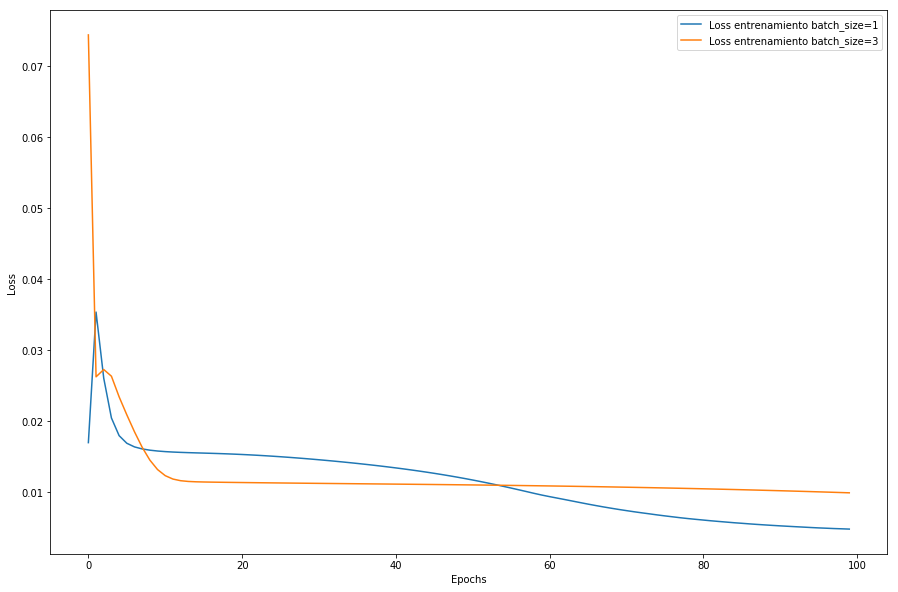

In [25]:
import matplotlib.pyplot as plt

plt.subplots(1,1,figsize=(15,10))
plt.subplot(1,1,1)
plt.plot(resultados2_l['loss'], label='Loss entrenamiento batch_size=1')
plt.plot(resultados2_m['loss'], label='Loss entrenamiento batch_size=3')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

El avance del entrenamiento es notoriamente ditinto. Se osbserva cómo el modelo de batch_size = 1 tiene a ajustarse o converger más que el modelo con batch_size = 3. Este último, también, comienza con un loss mucho mayor, y que converge a una velocidad muy alta, aunque, como se mencionó, no llega a mejorar al modelo de batch_size = 1.

Por supuesto, esto es sólo observando los losses de entrenamiento. Para obtener una comparación realente útil, se debe validar ambos modelos y observar los losses de validación por epoch.

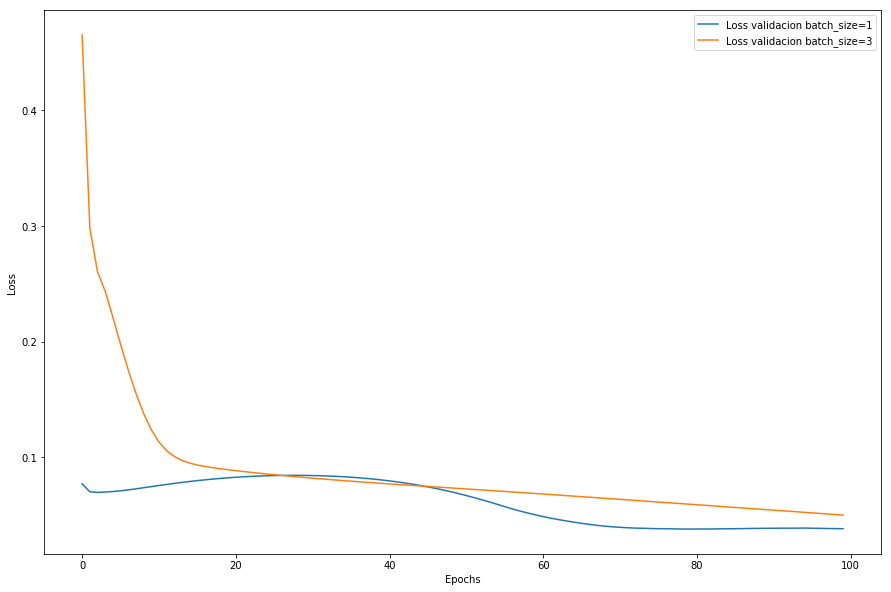

In [26]:
plt.subplots(1,1,figsize=(15,10))
plt.subplot(1,1,1)
plt.plot(resultados2_l['val_loss'], label='Loss validacion batch_size=1')
plt.plot(resultados2_m['val_loss'], label='Loss validacion batch_size=3')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show()

El comportamiento del loss de validación evidencia que el modelo de batch_size = 3 converge de manera más regular que el de batch_size = 1. Al final del entrenamiento, se nota que la pendiente del loss cuando batch_size = 3 sigue disminuyendo, mientras que la pendiente del loss cuando batch_size = 1 se ha vuelto ligeramente positiva a partir del epoch 80, volviendo disminuir en los últimos 5 epochs.

Por lo tanto, aquel modelo de batch_size = 3 es el que mejor se comporta durante el entrenamiento, demostrando una clara tendencia a mejorar el loss conforme se siga entrenando, posiblemente superando al modelo de batch_size = 1 en unos pocos epochs más allá del 100.

Respecto al modelo de batch_size = 1, notamos que, como su loss de entrenamiento sólo tiende a disminuir y no a converger, es mucho más probable que experimente overfitting con entrenamiento adicional. Esta es otra razón para creer que, con entrenamiento adicional, eventualmente el modelo de batch_size = 3 supere al de batch_size = 1.

#### (n) Construcción de red LSTM apilada. Comparación con lo obtenido en el ítem (k).

Se usará la red ya entrenada del ítem (l), que cumple el requerimiento de ser apilada (doble LSTM, tal como muestra el código de ejemplo del ítem). Se elige la de batch_size = 1 pues logró mejor loss de validación con el entrenamiento realizado.

In [28]:
trainPredict_k = modelo2_k.predict(trainX, batch_size=1)
trainPredict_n = modelo2_l.predict(trainX, batch_size=1)

In [29]:
trainPredict_k = scaler.inverse_transform(trainPredict_k)
trainPredict_n = scaler.inverse_transform(trainPredict_n)

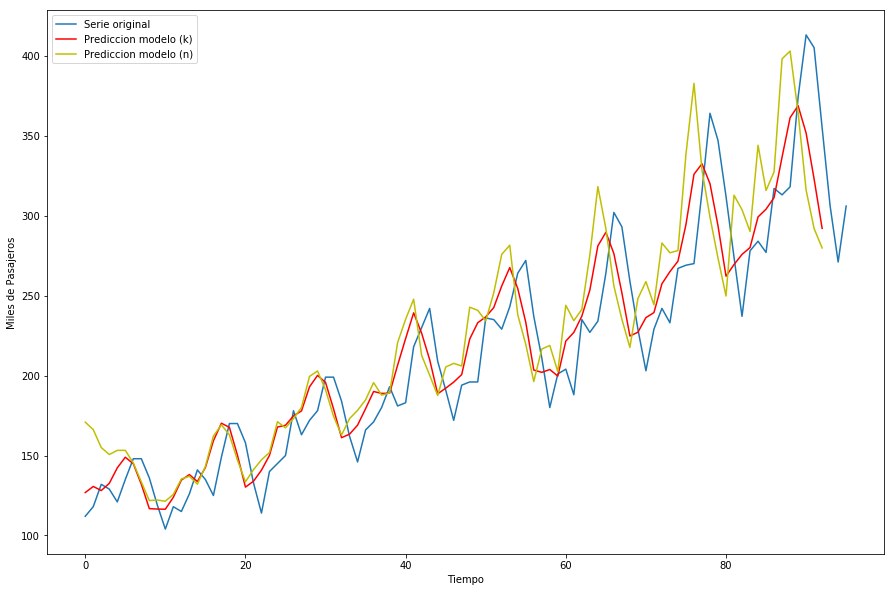

In [33]:
import matplotlib.pyplot as plt

plt.subplots(1,1,figsize=(15,10))
plt.subplot(1,1,1)
plt.plot(scaler.inverse_transform(stream_train_scaled), label='Serie original')
plt.plot(trainPredict_k, color='r', label='Prediccion modelo (k)')
plt.plot(trainPredict_n, color='y', label='Prediccion modelo (n)')
plt.ylabel('Miles de Pasajeros')
plt.xlabel('Tiempo')
plt.legend(loc='upper left')
plt.show()

Se nota que el modelo del ítem (k), que se entrenó usando timesteps=3, tiende menos a adoptar cambios en el patrón aprendido, pues, es notorio que los últimos tres peaks de pasajeros pronosticados por (k) se distancian más y más de los observados en la serie original. Esto es porque (k) aprendió de los peaks iniciales un aumento aproximadamente lineal de los mismos, lo que cambia a partir de la mitad de la serie. Frente a este cambio, el modelo (k) no se adapta, o no alcanza a hacerlo con la cantidad de entrenamiento realizado.

En cambio, la red LSTM apilada (n), que es el mismo modelo ya entrenado en (l), logra adaptarse al cambio mencionado, y más que adaptarse a los cambios en el patrón, es extremadamente sensible a éste. A partir de la mitad de la serie, donde los peaks ya no aumentan de forma aproximadamente lineal, sino que se nota un crecimiento aproximadamente exponencial, las predicciones del modelo (n) exageran ese nuevo comportamiento observado, sobreestimando la cantidad de pasajeros en los peaks. Sólo al final de la serie, la predicción de (n) parece ser más acertada, tanto en los peaks como en los valles.